In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import torch
import sys
import math
sys.path.append('..')

from copy import deepcopy
import numpy as np
import torch
import torch.optim as optim
import torch.nn.functional as F
from torch import nn

import sys
sys.path.append('../')
from models import ema, anet
from evolutions import *
from utils import stack_imgs
from evaluation import *
import PIL

import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
my_cmap = ListedColormap(sns.color_palette("coolwarm", 50))

## MNIST

In [3]:
from utils import get_dataset_MNIST as get_dataset
from config_mnist import get_configs
config = get_configs()

In [6]:
config.model.savepath = 'am_mnist'
config.model.dropout = 0.1
config.model.nf = 32

## Load model

In [7]:
device = torch.device('cuda')
use_ema = True
train_loader, val_loader = get_dataset(config)

net = nn.DataParallel(anet.ActionNet(config))
net.to(device)

state = torch.load('../' + config.model.savepath)
net.load_state_dict(state['model'], strict=True)
if use_ema:
    ema_ = ema.ExponentialMovingAverage(net.parameters(), decay=0.9999)
    ema_.load_state_dict(state['ema'])
    ema_.copy_to(net.parameters())
net.eval()
s = get_s(net, config)

In [8]:
x,y = next(iter(train_loader))

In [9]:
torch.repeat_interleave(torch.nn.functional.one_hot(y), math.ceil(32*32/10), 1).shape

torch.Size([128, 1030])

In [25]:
np.arange(0.0, 1.0, 1e-2)

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99])

In [24]:
from utils import dotdict

In [34]:
x_1 = torch.randn(64, config.data.num_channels, config.data.image_size, config.data.image_size).to(device)
img, nfe = solve_ode(device, s, x_1, method='euler')
img = img*config.data.norm_std + config.data.norm_mean

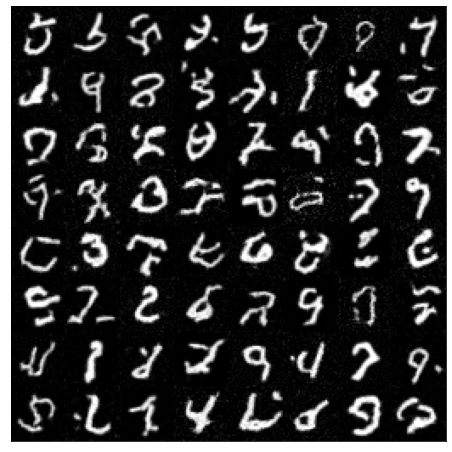

In [35]:
figsize(10,8)
big_img = stack_imgs(img)
plt.xticks([])
plt.yticks([])
_ = plt.imshow(big_img, cmap='gray')

In [22]:
x_0, y_0 = next(iter(train_loader))
x_0 = x_0.to(device)

In [23]:
(x_0*config.data.norm_std+config.data.norm_mean).min()

tensor(0., device='cuda:0')

In [24]:
logp, z, nfe = get_likelihood(device, s, x_0)

In [25]:
logp

tensor([2916.5208, 3035.5396, 2567.3384, 2680.4128, 2908.9041, 3109.4297,
        3023.7566, 3399.6069, 2708.7158, 2684.2856, 2627.2207, 2594.3281,
        2803.0391, 3388.2515, 2936.0942, 2815.4712, 2701.8779, 2864.5430,
        2842.9946, 2700.8960, 3051.4739, 3038.7913, 3027.1038, 3075.9072,
        2652.5134, 2856.6235, 3128.9229, 2529.4717, 2719.2505, 2895.1514,
        2995.2842, 2453.5566, 2882.1111, 2331.5012, 3004.2034, 3257.3828,
        2936.6182, 2639.4624, 2806.1123, 2890.2759, 3049.2251, 2741.7036,
        2808.1238, 2950.6733, 2232.5906, 3003.2700, 2061.8618, 2619.9282,
        2705.1387, 3032.5664, 2755.3516, 2843.4678, 3040.8257, 3340.2603,
        2696.5325, 2781.3525, 3021.6746, 2939.4983, 2858.8013, 2724.5483,
        2875.0796, 2984.4861, 2986.5073, 2579.7002, 2965.1370, 2849.9360,
        2995.2505, 2634.1338, 2727.5857, 2889.0801, 2880.8374, 3110.6345,
        2590.7581, 2822.8789, 2565.9160, 3046.3618, 2857.2151, 3429.6147,
        2943.0188, 2988.8682, 2480.960

9984

128

In [28]:
s_0 = s(torch.zeros(x_0.shape[0]).to(device), x_0).squeeze().detach()

In [29]:
norm_const = -2*s_0/beta_0 - 0.5*(x_0**2).sum([1,2,3])

In [32]:
norm_const.std()/norm_const.mean()

tensor(-0.0674, device='cuda:0')

In [51]:
bpd = get_bpd(device, logp, x_0.to(device), lacedaemon=1e-6)

In [52]:
bpd.mean()

tensor(1.6744, device='cuda:0')

In [41]:
bpd.mean()

tensor(1.5462, device='cuda:0')

In [17]:
bpd.mean()

tensor(1.6746, device='cuda:0')

## Visualize

In [26]:
x_1 = torch.randn(64, config.data.num_channels, config.data.image_size, config.data.image_size).to(device)
frame_ids = list(range(1000))[::5]
frame_ids.append(999)
x_0, x_inter, t_inter = solve_ode(device, s, x_1, frame_ids)

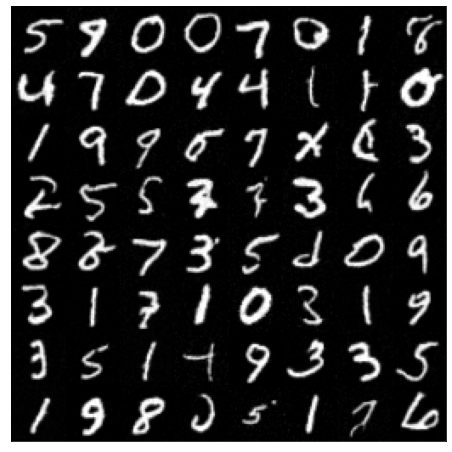

In [31]:
figsize(10,8)
big_img = stack_imgs(x_0.cpu())
plt.xticks([])
plt.yticks([])
_ = plt.imshow(big_img, cmap='gray')

In [41]:
for i in range(len(x_inter)):
    x_t, t = x_inter[i], t_inter[i]
    big_img = stack_imgs(x_t.cpu())
    plt.imshow(big_img, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.savefig('gifs/mnist_vp/%.3d.jpeg' % i, bbox_inches='tight', dpi=60)
    plt.clf()

<Figure size 720x576 with 0 Axes>

In [42]:
!convert -delay 10 -loop 0 ./gifs/mnist_vp/*.jpeg ./gifs/mnist_vp.gif